In [23]:
import csv
import os

from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import simdna
from simdna import synthetic
import statsmodels.api as sm
import torch
from tqdm.auto import tqdm, trange
import uncertainty_toolbox.data as udata
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from ensemble import Ensemble, CalibratedRegressionEnsemble
from utils import one_hot_decode
from in_silico_mutagenesis import compute_summary_statistics, generate_wt_mut_batches, write_results
from pyx.one_hot import one_hot
from tf_coop_model import CountsRegressor, IterablePandasDataset
from tf_coop_model import anscombe_transform, run_one_epoch, spearman_rho, pearson_r
from tf_coop_simulation import background_frequency
from tf_coop_simulation import simulate_counts, simulate_oracle_predictions

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
np.random.seed(42)

# Initialize Model & Load Weights
This step assumes we've trained a counts regression model and have its weights stored in a .pt[h] file somewhere accessible.

In [49]:
n_conv_layers = 3
n_dense_layers = 3
n_outputs = 2
sequence_length = 100
filters = 15
filter_width = 7
dense_layer_width = 30

data_dir = '../dat/sim'
weights_dir = os.path.join(data_dir, 'ensemble')
weights_fname = 'cnn_counts_predictor_with_variants.pt'
test_data_fpath = os.path.join(data_dir, 'test_labels.csv')
raw_simulation_data_fpath = os.path.join(data_dir, 'test_sequences.simdata')
mutagenesis_results_dir = os.path.join(data_dir, 'res')

os.makedirs(mutagenesis_results_dir, exist_ok=True)

sequences_col = "sequences"
label_cols = ["labels_exp", "labels_out"]
batch_size = 1000
n_samples = 10

includes_confounder = False
exposure_name = "TAL1"
outcome_name = "GATA"
exposure_col = 1
outcome_col = 0
outcome_motif = "GATA_disc1"
exposure_motif = "TAL1_known1"
confounder_motif = "SOX2_1" if includes_confounder else None

In [27]:
torch.set_grad_enabled(False)

In [28]:
test_df = pd.read_csv(test_data_fpath)
test_dataset = IterablePandasDataset(
    test_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
    y_transform=anscombe_transform
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0
)

In [29]:
params = {
    "n_conv_layers": n_conv_layers,
    "n_dense_layers": n_dense_layers,
    "n_outputs": n_outputs,
    "sequence_length": sequence_length,
    "filters": filters,
    "filter_width": filter_width,
    "dense_layer_width": dense_layer_width
}
ensemble_model = Ensemble(weights_dir, "cnn_counts_predictor.pt", params, n_reps=10)
calibrated_ensemble_model = CalibratedRegressionEnsemble(ensemble_model, test_data_loader)

# Load Test Data & Generate Predictions
Now we're going to load test data to get some basic metrics about how well our model performs.

# Running Deep MR
In Shrikumar et al, all effects are computed in raw counts space. Here, for purposes of making our result relevant to Deep MR, we compute interaction effects in both Anscombe-transformed space and raw counts space but focus on the validity of the former.

In [30]:
both_motifs_df = test_df[(test_df['has_exposure'] == 1) & (test_df['has_outcome'] == 1)]
exposure_motif_df = test_df[(test_df['has_exposure'] == 1) & (test_df['has_outcome'] == 0)]
outcome_motif_df = test_df[(test_df['has_exposure'] == 0) & (test_df['has_outcome'] == 1)]
neither_motif_df = test_df[
    (test_df['has_exposure'] == 0) & (test_df['has_outcome'] == 0)
]

In [31]:
len(both_motifs_df), len(exposure_motif_df), len(outcome_motif_df), len(neither_motif_df)

(2499, 2514, 2460, 2527)

In [32]:
both_motifs_dataset = IterablePandasDataset(
    both_motifs_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
    y_transform=anscombe_transform
)
both_motifs_data_loader = torch.utils.data.DataLoader(
    both_motifs_dataset, batch_size=batch_size, num_workers=0
)

In [33]:
def mutate_and_predict(model, sample_dataset, predictions_key = 'recal_predictions'):
    preds = {}
    all_muts = []
    for seq, label in tqdm(sample_dataset):
        muts = generate_wt_mut_batches(seq, seq.shape[0] * seq.shape[1]).squeeze()
        muts = muts.transpose(0, 1, 2)
        muts = torch.from_numpy(muts)
        label = torch.from_numpy(label)
        outputs = model.predict(muts)
        preds_np = outputs[predictions_key]
        exposure_preds = preds_np[:, :, 0]
        outcome_preds = preds_np[:, :, 1]
        preds.setdefault('exposure', []).append(exposure_preds)
        preds.setdefault('outcome', []).append(outcome_preds)
        all_muts.append(muts.detach().cpu().numpy())
    return all_muts, preds

In [34]:
# both_motifs_sample_dataset, _ = torch.utils.data.random_split(
#     both_motifs_dataset, (n_samples, len(both_motifs_dataset) - n_samples)
# )
both_motifs_sample_dataset = both_motifs_dataset

In [35]:
muts, recal_predictions = mutate_and_predict(
    calibrated_ensemble_model, both_motifs_sample_dataset
)
muts, uncal_predictions = mutate_and_predict(
    calibrated_ensemble_model, both_motifs_sample_dataset, predictions_key = 'predictions'
)
sample_seqs = np.array([seq for seq, label in both_motifs_sample_dataset])

In [45]:
# exposure_col = "exposure"
# outcome_col = "outcome"

# formatted_preds = np.stack((recal_predictions[exposure_col], recal_predictions[outcome_col]))
# n_features, n_seqs, n_reps, n_variants = formatted_preds.shape
# formatted_preds = formatted_preds.transpose(2, 1, 3, 0)
# formatted_preds = formatted_preds.reshape(n_reps, n_seqs, 4, -1, n_features)

# means, mean_diffs, stderrs = compute_summary_statistics(formatted_preds, np.array(sample_seqs))

np.save(
    os.path.join(mutagenesis_results_dir, f"{exposure_name}_{outcome_name}_means_calibrated_v2.npy"), 
    means
)
np.save(
    os.path.join(mutagenesis_results_dir, f"{exposure_name}_{outcome_name}__stderrs_calibrated_v2.npy"),
    stderrs
)

In [37]:
exposure_col = "exposure"
outcome_col = "outcome"

formatted_preds = np.stack((uncal_predictions[exposure_col], uncal_predictions[outcome_col]))
n_features, n_seqs, n_reps, n_variants = formatted_preds.shape
formatted_preds = formatted_preds.transpose(2, 1, 3, 0)
formatted_preds = formatted_preds.reshape(n_reps, n_seqs, 4, -1, n_features)

unc_means, unc_mean_diffs, unc_stderrs = compute_summary_statistics(formatted_preds, np.array(sample_seqs))

In [38]:
unc_stderrs.shape

(2499, 3, 100, 2)

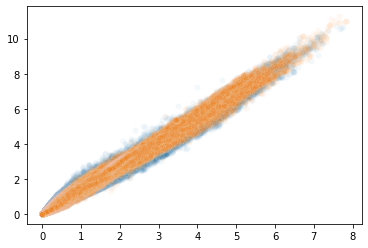

In [50]:
sns.scatterplot(unc_stderrs[:, :, :, exposure_col].flatten(), stderrs[:, :, :, exposure_col].flatten(), alpha = 0.05)
sns.scatterplot(unc_stderrs[:, :, :, outcome_col].flatten(), stderrs[:, :, :, outcome_col].flatten(), alpha = 0.05)

In [40]:
def write_results(result_fpath, diffs, stderrs, x_col=0, y_col=1, sig_idxs=None):
    fieldnames = [
        "seq_num",
        "X_pred_mean",
        "X_pred_var",
        "Y_pred_mean",
        "Y_pred_var",
    ]
    if sig_idxs is None:
        sig_idxs = np.full(diffs.shape, True, dtype=bool)
    
    with open(result_fpath, "w", newline="") as out_file:
        writer = csv.DictWriter(out_file, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()

        n_seqs, n_muts, seq_len, _ = diffs.shape
        for seq_idx in range(n_seqs):
            for seq_pos in range(seq_len):
                for nt_pos in range(n_muts):
                    if sig_idxs[seq_idx, nt_pos, seq_pos]:
                        x_eff_size = diffs[seq_idx, nt_pos, seq_pos, x_col]
                        y_eff_size = diffs[seq_idx, nt_pos, seq_pos, y_col]
                        x_stderr = stderrs[seq_idx, nt_pos, seq_pos, x_col]
                        y_stderr = stderrs[seq_idx, nt_pos, seq_pos, y_col]
                        writer.writerow(
                            {
                                "seq_num": seq_idx + 1,
                                "X_pred_mean": x_eff_size,
                                "X_pred_var": x_stderr,
                                "Y_pred_mean": y_eff_size,
                                "Y_pred_var": y_stderr,
                            }
                        )



In [51]:
from filter_instrument_candidates import filter_variants_by_score
sig_var_idxs = filter_variants_by_score(mean_diffs[:, :, :, 1])
print(
    "Reduced number of instruments down from %d to %d (%.2f %%)" % 
    (np.prod(mean_diffs.shape), len(np.nonzero(sig_var_idxs)[0]), 
     float(len(np.nonzero(sig_var_idxs)[0]) / np.prod(mean_diffs.shape)) * 100)
)
results_fname = f'{exposure_name}_{outcome_name}_effect_sizes_calibrated_v2.csv'
results_fpath = os.path.join(mutagenesis_results_dir, results_fname)
write_results(results_fpath, mean_diffs, stderrs, sig_idxs = sig_var_idxs, x_col = exposure_col, y_col = outcome_col)

Reduced number of instruments down from 1499400 to 100227 (6.68 %)


In [42]:
ols_results = []
for i in trange(len(sample_seqs)):
    if mean_diffs[i, sig_var_idxs[i, :, :], 0].shape[0] > 0:
        x = sm.add_constant(mean_diffs[i, sig_var_idxs[i, :, :], 0].flatten(), prepend=False)
        y = mean_diffs[i, sig_var_idxs[i, :, :], 1].flatten()
        ols_res = sm.OLS(y, x).fit()
        ols_results.append(ols_res)

In [52]:
seq_cis = [r.params[0] for r in ols_results]